# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\yogesh.dayma\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
#Use the link in readme to download the dataset

con = sqlite3.connect('database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:52<00:00, 2112.91it/s]


In [23]:
preprocessed_reviews

['witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college',
 'grew reading sendak books watching really rosie movie incorporates love son loves however miss hard cover version paperbacks seem kind flimsy takes two hands keep pages open',
 'fun way children learn months year learn poems throughout school year like handmotions invent poem',
 'great little book read aloud nice rhythm well good repetition little ones like lines chicken soup rice child gets go months year go wonderful places like bombay nile eating well know get eat kids maurice sendak version ice skating treat roses heads long time not even know came surprise came little witty book',
 'book poetry months year goes month cute little poem go along love book really fun way learn months poems creative author purpose writing book give children fun way learn months

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

  0%|                                                                           | 224/364171 [00:00<02:43, 2223.69it/s]C:\Users\yogesh.dayma\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
  6%|████▌                                                                    | 22497/364171 [00:09<02:15, 2528.41it/s]C:\Users\yogesh.dayma\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 10%|███████▏                                                                 | 35931/364171 [00:14<02:11, 2490.37it/s]C:\Users\yogesh.dayma\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" lo

# [4] Featurization

### Splitting the final data into Training data, Cross-Validation data and Test data

In [24]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
#SPLITTING THE DATA FOR TRAINING AND TESTING
X1,Xtest,y1,ytest = cross_validation.train_test_split(preprocessed_reviews[:100000],final['Score'][:100000],test_size = 0.2)

C:\Users\yogesh.dayma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
#Splitting the training data into train and cross validate
Xtrain,Xcv,ytrain,ycv = cross_validation.train_test_split(X1,y1,test_size=0.25)

## [4.1] BAG OF WORDS

In [26]:
#BoW
count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
count_vect.fit(Xtrain)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(Xtrain)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 500)
the number of unique words  500


In [27]:
from scipy.sparse import spmatrix
BOW_Train = count_vect.transform(Xtrain)
BOW_CV = count_vect.transform(Xcv)
BOW_Test = count_vect.transform(Xtest)
print(BOW_Test.shape)
print(type(BOW_Train))
BOW_Train_dense = BOW_Train.toarray()
BOW_CV_dense = BOW_CV.toarray()
BOW_Test_dense = BOW_Test.toarray()
print(type(BOW_Train_dense))

(20000, 500)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


In [38]:
print(BOW_Test_dense.shape)
print(svd_test.shape)

(20000, 500)
(20000, 300)


Text(0,0.5,'cumulative explained variance')

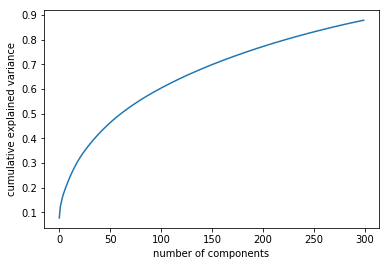

In [28]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=10)

#Reducing the dimensionality of the BOW vectors so that we can apply K-fold cross validation
svd_train = svd.fit(BOW_Train)
svd_train = svd.transform(BOW_Train)
svd_cv = svd.transform(BOW_CV)
svd_test = svd.transform(BOW_Test)

svd_train.shape
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## [4.2] Bi-Grams and n-Grams.

In [45]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(Xtrain)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [46]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(Xtrain)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(Xtrain)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 500)
the number of unique words including both unigrams and bigrams  500


In [47]:
tfidf_train = tf_idf_vect.transform(Xtrain)
tfidf_cv = tf_idf_vect.transform(Xcv)
tfidf_test = tf_idf_vect.transform(Xtest)

tfidf_test_dense = tfidf_test.toarray()
tfidf_train_dense = tfidf_train.toarray()
tfidf_cv_dense = tfidf_cv.toarray()

In [48]:
#Reducing the dimensionality of the tfidf vectors so that we can apply K-fold cross validation
svd_train = svd.transform(tfidf_train)
svd_cv = svd.transform(tfidf_cv)
svd_test = svd.transform(tfidf_test)

## [4.4] Avg Word2Vec

In [130]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [132]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

C:\Users\yogesh.dayma\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [135]:
w2v_words = list(w2v_model.wv.vocab)
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [01:19<00:00, 582.45it/s]


In [176]:
#SPLITTING THE DATA FOR TRAINING AND TESTING
X1,Xtest,y1,ytest = cross_validation.train_test_split(sent_vectors,final['Score'],test_size = 0.3)
#Splitting the training data into train and cross validate
Xtrain,Xcv,ytrain,ycv = cross_validation.train_test_split(X1,y1,test_size=0.3)

In [177]:
#Reducing the dimensionality of the W2Vec vectors so that we can apply K-fold cross validation
svd_train = svd.fit_transform(Xtrain)
svd_cv = svd.fit_transform(Xcv)
svd_test = svd.fit_transform(Xtest)

## [4.4.1] Converting text into vectors using TFIDF-W2V

In [145]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [01:31<00:00, 505.17it/s]


46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [146]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [147]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 46071/46071 [13:49<00:00, 55.52it/s]


In [182]:
#SPLITTING THE DATA FOR TRAINING AND TESTING
X1,Xtest,y1,ytest = cross_validation.train_test_split(tfidf_sent_vectors,final['Score'],test_size = 0.3)
#splitting the training and cross validation data
Xtrain,Xcv,ytrain,ycv = cross_validation.train_test_split(X1,y1,test_size=0.3)

In [183]:
#Reducing the dimensionality of the tfidf vectors so that we can apply K-fold cross validation
svd_train = svd.fit_transform(Xtrain)
svd_cv = svd.fit_transform(Xcv)
svd_test = svd.fit_transform(Xtest)

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

##### Training the model and finding the optimal hyperparameter by using GridSearchCV 10-fold cross-validation by using BoW vectors. Plotting the Error plot and chosing the best hyperparameter such that, we will have maximum AUC on cv data and gap between the train and cv is less

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = list(range(1, 31))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(svd_train, ytrain)
    y_train_pred =  neigh.predict_proba(svd_train)[:,1]
    y_cv_pred =  neigh.predict_proba(svd_cv)[:,1]
    
    train_auc.append(roc_auc_score(ytrain,y_train_pred))
    cv_auc.append(roc_auc_score(ycv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [42]:
# Here we are chosing the best K by observing the AUC curve for each hyperparameter
best_k = 25

##### Testing with test data and plotting error plot and confusion matrix for the best hyperparameter we selected

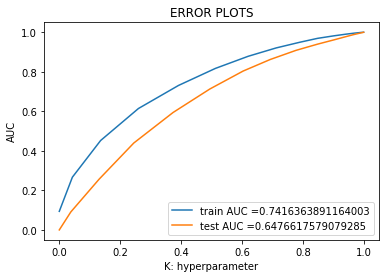

Train confusion matrix
[[  279  8678]
 [  235 50808]]
Test confusion matrix
[[   47  2861]
 [  103 16989]]


In [43]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(svd_train, ytrain)

train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(svd_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(ytest, neigh.predict_proba(svd_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain, neigh.predict(svd_train)))
print("Test confusion matrix")
print(confusion_matrix(ytest, neigh.predict(svd_test)))

##### Displaying all the performance metrics of the model by using classification report

In [44]:
from sklearn.metrics import classification_report
print(classification_report(ytest, neigh.predict(svd_test)))

             precision    recall  f1-score   support

          0       0.31      0.02      0.03      2908
          1       0.86      0.99      0.92     17092

avg / total       0.78      0.85      0.79     20000



### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

##### Training the model and finding the optimal hyperparameter by using GridSearchCV 10-fold cross-validation by using TFIDF vectors. Plotting the Error plot and chosing the best hyperparameter such that, we will have maximum AUC on cv data and gap between the train and cv is less

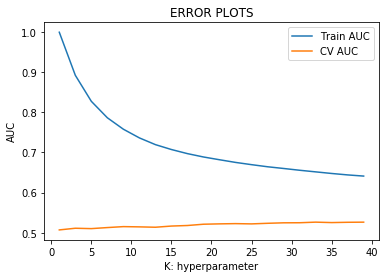

In [49]:
from sklearn.model_selection import GridSearchCV
K = list(range(1, 41))
neigh = KNeighborsClassifier()
neighbors = list(filter(lambda x: x % 2 != 0, K))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, cv=10, scoring='roc_auc',n_jobs=-1)
clf.fit(svd_train, ytrain)

train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 

plt.plot(neighbors, train_auc, label='Train AUC')

plt.plot(neighbors, cv_auc, label='CV AUC')

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [50]:
# Here we are chosing the best K by observing the AUC curve for each hyperparameter
best_k = 19

##### Testing with test data and plotting error plot and confusion matrix for the best hyperparameter we selected

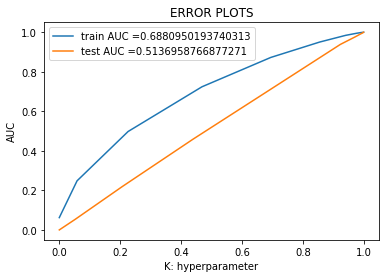

Train confusion matrix
[[   28  8929]
 [   26 51017]]
Test confusion matrix
[[    4  2904]
 [   22 17070]]


In [51]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(svd_train, ytrain)

train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(svd_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(ytest, neigh.predict_proba(svd_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain, neigh.predict(svd_train)))
print("Test confusion matrix")
print(confusion_matrix(ytest, neigh.predict(svd_test)))

##### Displaying all the performance metrics of the model by using classification report

In [52]:
print(classification_report(ytest, neigh.predict(svd_test)))

             precision    recall  f1-score   support

          0       0.15      0.00      0.00      2908
          1       0.85      1.00      0.92     17092

avg / total       0.75      0.85      0.79     20000



### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

##### Training the model and finding the optimal hyperparameter by using GridSearchCV 10-fold cross-validation by using AVG W2Vec. Plotting the Error plot and chosing the best hyperparameter such that, we will have maximum AUC on cv data and gap between the train and cv is less

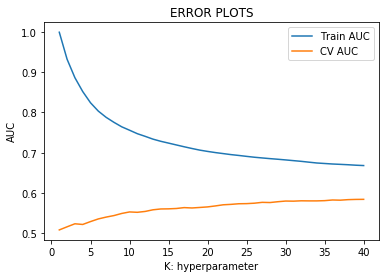

In [141]:
from sklearn.model_selection import GridSearchCV
K = list(range(1, 41))
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':K}
clf = GridSearchCV(neigh, parameters, cv=10, scoring='roc_auc',n_jobs=-1)
clf.fit(svd_train, ytrain)

train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [142]:
# Here we are chosing the best K by observing the AUC curve for each hyperparameter
best_k = 36

##### Testing with test data and plotting error plot and confusion matrix for the best hyperparameter we selected

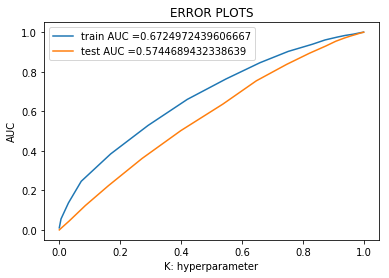

Train confusion matrix
[[   22  3698]
 [   20 18834]]
Test confusion matrix
[[    6  2245]
 [    8 11563]]


In [143]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(svd_train, ytrain)

train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(svd_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(ytest, neigh.predict_proba(svd_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain, neigh.predict(svd_train)))
print("Test confusion matrix")
print(confusion_matrix(ytest, neigh.predict(svd_test)))

##### Displaying all the performance metrics of the model by using classification report

In [144]:
print(classification_report(ytest, neigh.predict(svd_test)))

             precision    recall  f1-score   support

          0       0.43      0.00      0.01      2251
          1       0.84      1.00      0.91     11571

avg / total       0.77      0.84      0.76     13822



### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

##### Training the model and finding the optimal hyperparameter by using GridSearchCV 10-fold cross-validation by using TFIDF W2Vec. Plotting the Error plot and chosing the best hyperparameter such that, we will have maximum AUC on cv data and gap between the train and cv is less

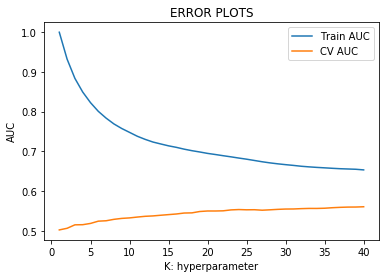

In [150]:
from sklearn.model_selection import GridSearchCV
K = list(range(1, 41))
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':K}
clf = GridSearchCV(neigh, parameters, cv=10, scoring='roc_auc',n_jobs=-1)
clf.fit(svd_train, ytrain)

train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [151]:
# Here we are chosing the best K by observing the AUC curve for each hyperparameter
best_k = 37

##### Testing with test data and plotting error plot and confusion matrix for the best hyperparameter we selected

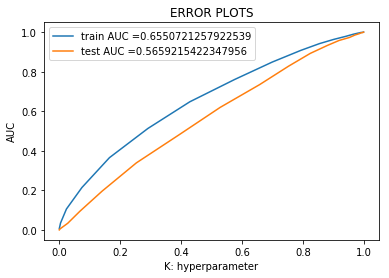

Train confusion matrix
[[   10  3649]
 [    7 18908]]
Test confusion matrix
[[    3  2311]
 [    6 11502]]


In [152]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(svd_train, ytrain)

train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(svd_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(ytest, neigh.predict_proba(svd_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain, neigh.predict(svd_train)))
print("Test confusion matrix")
print(confusion_matrix(ytest, neigh.predict(svd_test)))

##### Displaying all the performance metrics of the model by using classification report

In [153]:
print(classification_report(ytest, neigh.predict(svd_test)))

             precision    recall  f1-score   support

          0       0.33      0.00      0.00      2314
          1       0.83      1.00      0.91     11508

avg / total       0.75      0.83      0.76     13822



## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

##### Training the model by kd-tree algorithm and finding the optimal hyperparameter by using GridSearchCV 10-fold cross-validation by using BOW vectors. Plotting the Error plot and chosing the best hyperparameter such that, we will have maximum AUC on cv data and gap between the train and cv is less

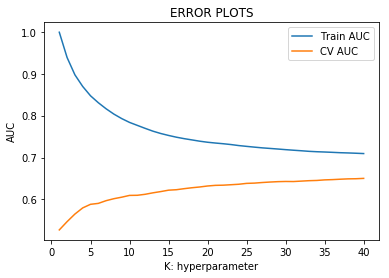

In [165]:
from sklearn.model_selection import GridSearchCV
K = list(range(1, 41))
neigh = KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1)
parameters = {'n_neighbors':K}
clf = GridSearchCV(neigh, parameters, cv=10, scoring='roc_auc',n_jobs=-1)
clf.fit(svd_train, ytrain)

train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [166]:
best_k = 40

##### Testing with test data and plotting error plot and confusion matrix for the best hyperparameter we selected


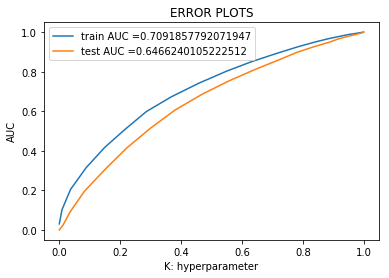

Train confusion matrix
[[   23  3669]
 [   19 18863]]
Test confusion matrix
[[    6  2296]
 [   10 11510]]


In [167]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree', n_jobs=-1)
neigh.fit(svd_train, ytrain)

train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(svd_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(ytest, neigh.predict_proba(svd_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain, neigh.predict(svd_train)))
print("Test confusion matrix")
print(confusion_matrix(ytest, neigh.predict(svd_test)))

##### Displaying all the performance metrics of the model by using classification report

In [168]:
print(classification_report(ytest, neigh.predict(svd_test)))

             precision    recall  f1-score   support

          0       0.38      0.00      0.01      2302
          1       0.83      1.00      0.91     11520

avg / total       0.76      0.83      0.76     13822



### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

##### Training the model by kd-tree algorithm and finding the optimal hyperparameter by using GridSearchCV 10-fold cross-validation by using TFIDF vectors. Plotting the Error plot and chosing the best hyperparameter such that, we will have maximum AUC on cv data and gap between the train and cv is less

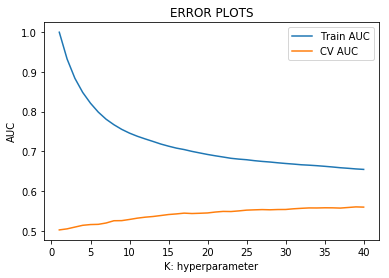

In [172]:
from sklearn.model_selection import GridSearchCV
K = list(range(1, 41))
neigh = KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1)
parameters = {'n_neighbors':K}
clf = GridSearchCV(neigh, parameters, cv=10, scoring='roc_auc',n_jobs=-1)
clf.fit(svd_train, ytrain)

train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [173]:
best_k = 38

##### Testing with test data and plotting error plot and confusion matrix for the best hyperparameter we selected

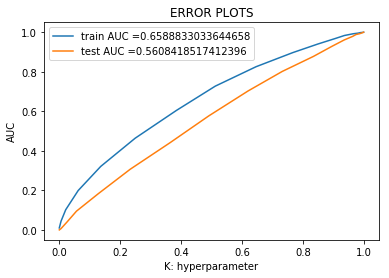

Train confusion matrix
[[    3  3689]
 [    5 18877]]
Test confusion matrix
[[    0  2302]
 [    3 11517]]


In [174]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree', n_jobs=-1)
neigh.fit(svd_train, ytrain)

train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(svd_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(ytest, neigh.predict_proba(svd_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain, neigh.predict(svd_train)))
print("Test confusion matrix")
print(confusion_matrix(ytest, neigh.predict(svd_test)))

##### Displaying all the performance metrics of the model by using classification report

In [175]:
print(classification_report(ytest, neigh.predict(svd_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2302
          1       0.83      1.00      0.91     11520

avg / total       0.69      0.83      0.76     13822



### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

##### Training the model by kd-tree algorithm and finding the optimal hyperparameter by using GridSearchCV 10-fold cross-validation by using AVG Word2Vec. Plotting the Error plot and chosing the best hyperparameter such that, we will have maximum AUC on cv data and gap between the train and cv is less

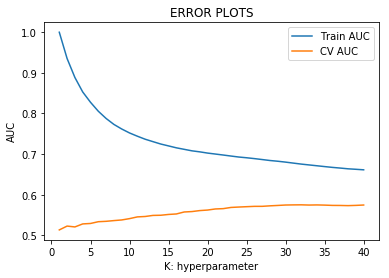

In [178]:
from sklearn.model_selection import GridSearchCV
K = list(range(1, 41))
neigh = KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1)
parameters = {'n_neighbors':K}
clf = GridSearchCV(neigh, parameters, cv=10, scoring='roc_auc',n_jobs=-1)
clf.fit(svd_train, ytrain)

train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [179]:
best_k = 30

##### Testing with test data and plotting error plot and confusion matrix for the best hyperparameter we selected

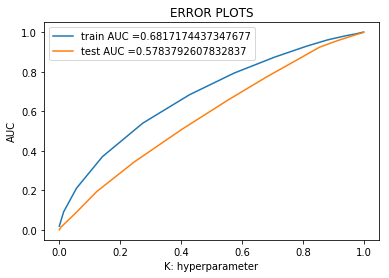

Train confusion matrix
[[    8  3637]
 [    9 18920]]
Test confusion matrix
[[    1  2399]
 [    9 11413]]


In [180]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree', n_jobs=-1)
neigh.fit(svd_train, ytrain)

train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(svd_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(ytest, neigh.predict_proba(svd_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain, neigh.predict(svd_train)))
print("Test confusion matrix")
print(confusion_matrix(ytest, neigh.predict(svd_test)))

##### Displaying all the performance metrics of the model by using classification report

In [181]:
print(classification_report(ytest, neigh.predict(svd_test)))

             precision    recall  f1-score   support

          0       0.10      0.00      0.00      2400
          1       0.83      1.00      0.90     11422

avg / total       0.70      0.83      0.75     13822



### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

##### Training the model by kd-tree algorithm and finding the optimal hyperparameter by using GridSearchCV 10-fold cross-validation by using TFIDF Word2Vec. Plotting the Error plot and chosing the best hyperparameter such that, we will have maximum AUC on cv data and gap between the train and cv is less

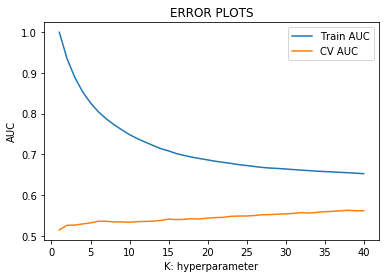

In [184]:
from sklearn.model_selection import GridSearchCV
K = list(range(1, 41))
neigh = KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1)
parameters = {'n_neighbors':K}
clf = GridSearchCV(neigh, parameters, cv=10, scoring='roc_auc',n_jobs=-1)
clf.fit(svd_train, ytrain)

train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [185]:
best_k = 38

##### Testing with test data and plotting error plot and confusion matrix for the best hyperparameter we selected

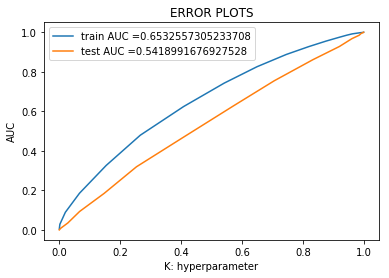

Train confusion matrix
[[    7  3714]
 [    7 18846]]
Test confusion matrix
[[    0  2247]
 [    0 11575]]


In [186]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree', n_jobs=-1)
neigh.fit(svd_train, ytrain)

train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(svd_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(ytest, neigh.predict_proba(svd_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain, neigh.predict(svd_train)))
print("Test confusion matrix")
print(confusion_matrix(ytest, neigh.predict(svd_test)))

##### Displaying all the performance metrics of the model by using classification report

In [187]:
print(classification_report(ytest, neigh.predict(svd_test)))

C:\Users\yogesh.dayma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2247
          1       0.84      1.00      0.91     11575

avg / total       0.70      0.84      0.76     13822



# [6] Conclusions

In [191]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
#this code is copied from here: http://zetcode.com/python/prettytable/ 

x = PrettyTable()

x.field_names = ["Model name", "Precision", "Recall"]

x.add_row(["BOW(brute)", 0.75, 0.83])
x.add_row(["BOW(KD-tree)", 0.76, 0.83])
x.add_row(["TF-IDF(brute)", 0.69, 0.83])
x.add_row(["TF-IDF(Kd-tree)", 0.69, 0.83])
x.add_row(["Avg-Word2Vec(brute)", 0.77, 0.84])
x.add_row(["Avg-Word2Vec(Kd-tree)", 0.70, 0.83])
x.add_row(["TFIDF-Word2Vec(brute)", 0.75, 0.83])
x.add_row(["TFIDF-Word2Vec(Kd-tree)", 0.70, 0.84])

print(x)

+-------------------------+-----------+--------+
|        Model name       | Precision | Recall |
+-------------------------+-----------+--------+
|        BOW(brute)       |    0.75   |  0.83  |
|       BOW(KD-tree)      |    0.76   |  0.83  |
|      TF-IDF(brute)      |    0.69   |  0.83  |
|     TF-IDF(Kd-tree)     |    0.69   |  0.83  |
|   Avg-Word2Vec(brute)   |    0.77   |  0.84  |
|  Avg-Word2Vec(Kd-tree)  |    0.7    |  0.83  |
|  TFIDF-Word2Vec(brute)  |    0.75   |  0.83  |
| TFIDF-Word2Vec(Kd-tree) |    0.7    |  0.84  |
+-------------------------+-----------+--------+


As we can see from above table all of the models performs quite similar but KNN with Avg-Word2Vec(brute) provides the best Precision and Recall. Hence can be called as the best model for this dataset as the dataset is skewed towards the positive points.